In [1]:
from BPMQ_model import TISRAW2BPMQ_model, train_TISRAW2BPMQ_model, sort_by_Dnum
from TIS161_coeffs import TIS161_coeffs

In [2]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import torch
import os
_dtype = torch.float32

import warnings
warnings.filterwarnings("ignore", category=UserWarning, message="To copy construct from a tensor")

In [3]:
data_path = './train_data/'
epochs = 500
lr = 2e-3

# prior data

LS3_BTS:BPM_D4753 832
LS3_BTS:BPM_D4769 832
LS3_BTS:BPM_D4843 832
LS3_BTS:BPM_D4886 832
LS3_BTS:BPM_D4968 832
LS3_BTS:BPM_D5010 832
LS3_BTS:BPM_D5092 832
LS3_BTS:BPM_D5134 832
LS3_BTS:BPM_D5216 832
LS3_BTS:BPM_D5259 832
LS3_BTS:BPM_D5340 832
LS3_BTS:BPM_D5381 832
LS3_BTS:BPM_D5430 832
LS3_BTS:BPM_D5445 832
BDS_BTS:BPM_D5499 832
BDS_BTS:BPM_D5513 929
BDS_BTS:BPM_D5565 929


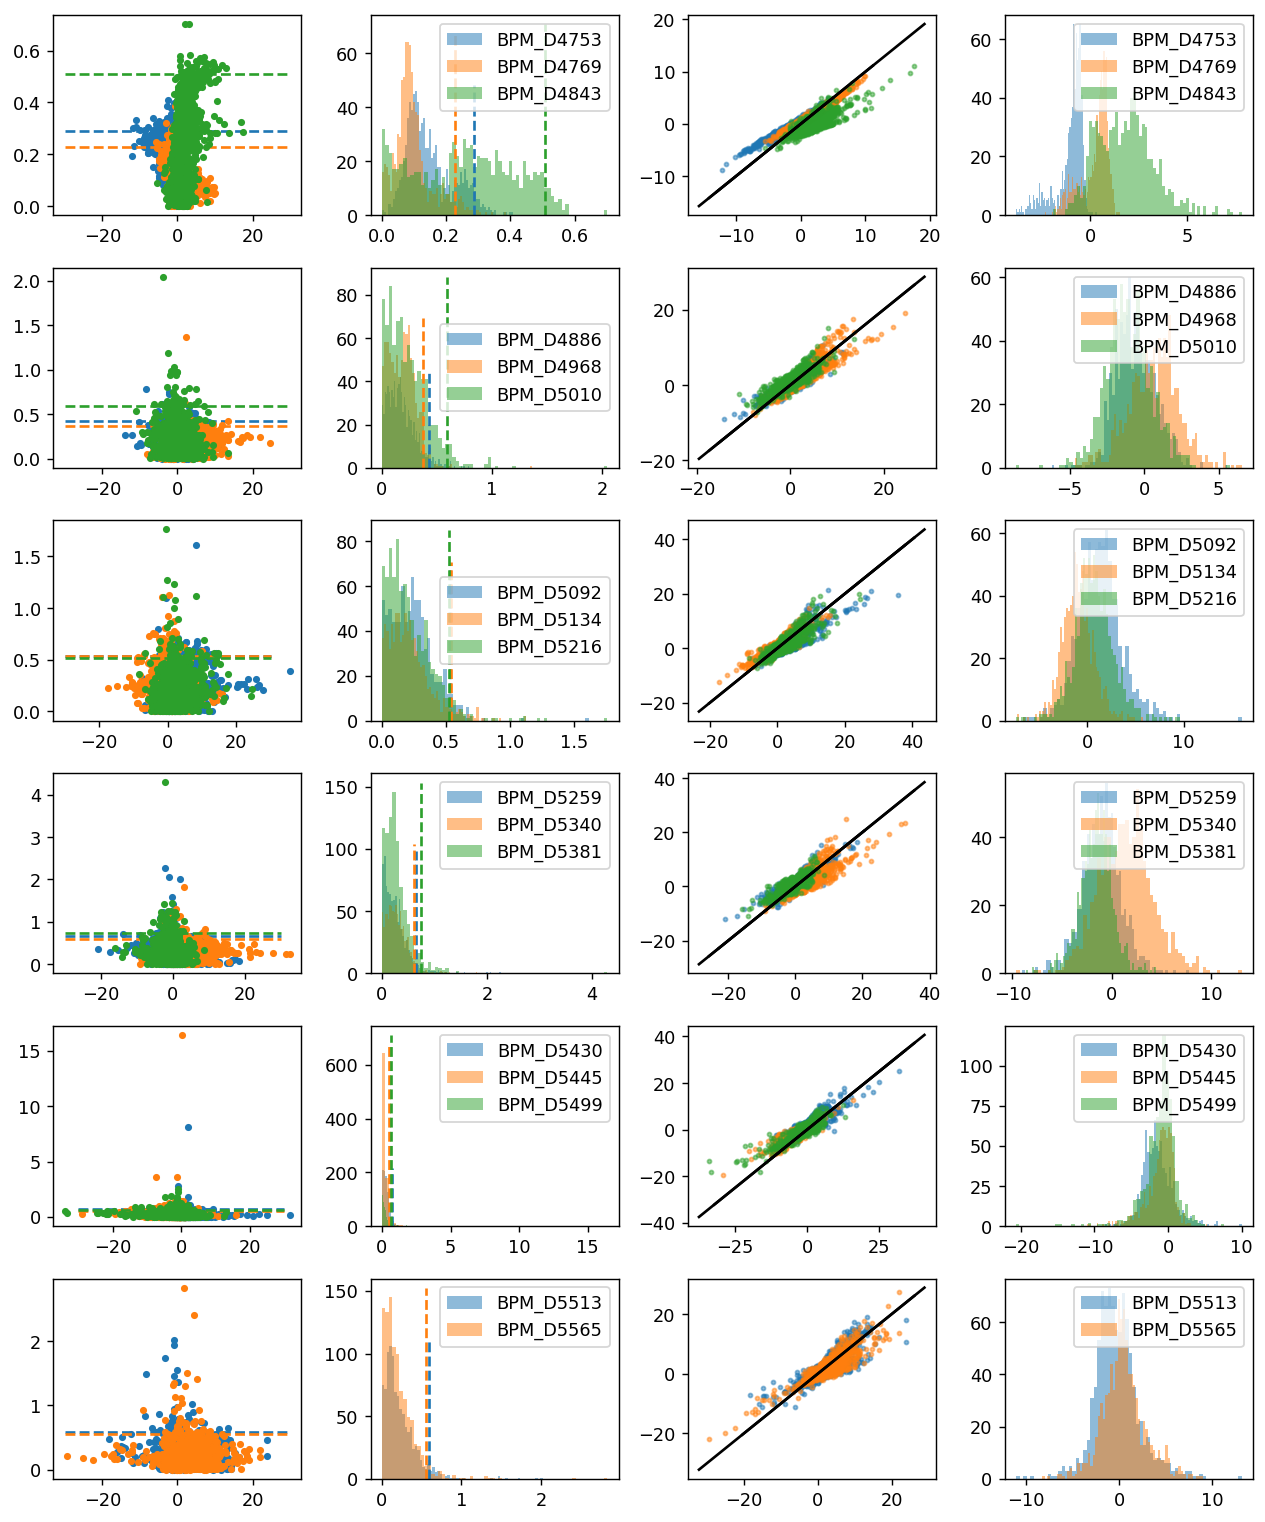

In [4]:
prior_data_files = [
     #'20231117_Ca_LS3exit_beamQ_PM5567_PMver0.pkl',
     '20231130_36Ar18_afterVslitAdjust_LS3exit_beamQ_corrScan_PM4771_PM5567_PMver0.pkl',
     '20231130_36Ar18_afterVslitAdjust_LS3exit_beamQ_PM4771_PM5567_PMver0.pkl',
     '20231130_36Ar18_beforeVslitAdjust_LS3exit_beamQ_PM4771_PM5567_PMver0.pkl',
     '20240119_82Se32_LS3exit_beamQ_PM4771_PM5567_PMver0.pkl',
     '20240321_BDSentrance_corrScan_beamQ_PM5567_PMver0.pkl',
     '20240709_BDSentrance_beamQ_PM5567_PMver0.pkl']

prior_data = {'measurement':[],
              'simulation':[]}
for f in prior_data_files:
    tmp = pickle.load(open(data_path+f,'rb'))
    prior_data['measurement'].append(tmp['measurement'])
    prior_data['simulation'].append(tmp['simulation'])

for k,v in prior_data.items():
    prior_data[k] = pd.concat(v,ignore_index=True)

fig,ax = plt.subplots(6,4,figsize=(10,2*6), dpi=128)
BPMs = sort_by_Dnum(list(prior_data['measurement'].columns.get_level_values(0).unique()))
for i,bpm in enumerate(BPMs):
    meas = prior_data['measurement'][bpm]
    mask = prior_data['measurement'][bpm].notna().all(axis=1)
    meas = meas[mask]
    sim  = prior_data['simulation'][bpm][mask]
    loss =  np.sqrt((meas['beamQ']-sim['beamQ'])**2/(np.abs(sim['beamQ'])+5)**2)
    cut = np.sort(loss)[int(0.95*len(loss))] 
    mask = loss < cut
    prior_data[bpm] = {'measurement':meas[mask],
                       'simulation':sim[mask]}
    
    n = int(i/(len(BPMs)/6))
    c = 'C'+str(i%3)
    ax[n,0].plot(sim['beamQ'],loss,'.',c=c,label=bpm[8:])
    ax[n,0].plot([-30,30],[cut,cut],c=c,ls='--')
    ax[n,1].hist(loss,bins=64,alpha=0.5,color=c,label=bpm[8:])
    ax[n,1].plot([cut,cut],ax[n,1].get_ylim(),c=c,ls='--')
    ax[n,2].scatter(prior_data[bpm]['simulation']['beamQ'],prior_data[bpm]['measurement']['beamQ'],alpha=0.5,color=c,label=bpm[8:],s=5)
    ax[n,2].plot(ax[n,2].get_xlim(),ax[n,2].get_xlim(),color='k')
    ax[n,3].hist(prior_data[bpm]['simulation']['beamQ']-prior_data[bpm]['measurement']['beamQ'],bins=64,alpha=0.5,color=c,label=bpm[8:])
    
for i in range(6):
    for j in [1,3]:
        ax[i,j].legend()
plt.tight_layout()

prior_T1 = {}
prior_T2 = {}
prior_T3 = {}
prior_T4 = {}
prior_xy = {}
prior_Qsim = {}
prior_Qmeas = {}
prior_Qerr = {}
np.random.seed(0)
for bpm in BPMs:
    meas = prior_data[bpm]['measurement']
    sim  = prior_data[bpm]['simulation']
    n_data = len(meas)
    print(bpm,n_data)
    p = np.random.permutation(np.arange(n_data))
    # normalize TISRAW
    T1 = np.stack(meas['TISRAW1'].values)/ meas["MAG"].values[:, None] *TIS161_coeffs[bpm][0] *1.1e-11 + 0.5
    T2 = np.stack(meas['TISRAW2'].values)/ meas["MAG"].values[:, None] *TIS161_coeffs[bpm][1] *1.1e-11 + 0.5
    T3 = np.stack(meas['TISRAW3'].values)/ meas["MAG"].values[:, None] *TIS161_coeffs[bpm][2] *1.1e-11 + 0.5
    T4 = np.stack(meas['TISRAW4'].values)/ meas["MAG"].values[:, None] *TIS161_coeffs[bpm][3] *1.1e-11 + 0.5
    prior_T1   [bpm] = torch.tensor(T1[p],dtype=_dtype)
    prior_T2   [bpm] = torch.tensor(T2[p],dtype=_dtype)
    prior_T3   [bpm] = torch.tensor(T3[p],dtype=_dtype)
    prior_T4   [bpm] = torch.tensor(T4[p],dtype=_dtype)
    prior_xy   [bpm] = torch.tensor(np.stack(meas[['XPOS','YPOS']].values[p]),dtype=_dtype)
    prior_Qsim [bpm] = torch.tensor(sim['beamQ'  ].values[p],dtype=_dtype)
    prior_Qmeas[bpm] = torch.tensor(meas['beamQ'  ].values[p],dtype=_dtype)
    prior_Qerr [bpm] = torch.tensor(meas['beamQ_err'].values[p],dtype=_dtype)

#### check normalized TISRAW in prior data

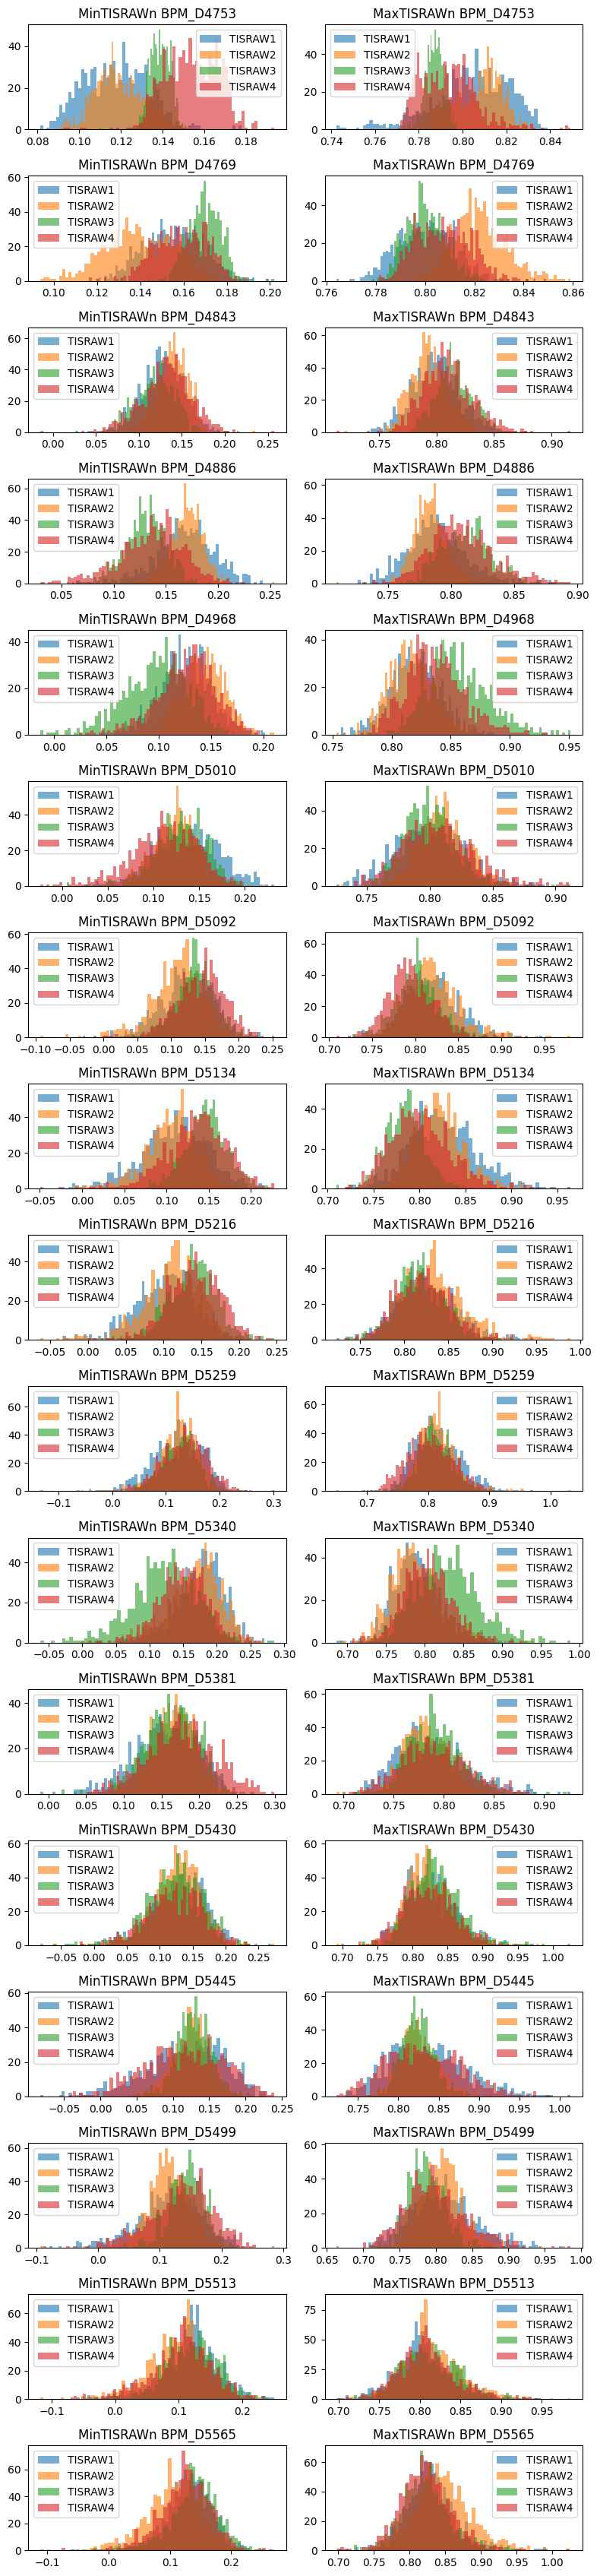

In [5]:
fig,ax = plt.subplots(len(BPMs),2,figsize=(8, 2*len(BPMs)))

for ibpm,bpm in enumerate(BPMs):
    
    min_values = [min(lst) for lst in prior_T1[bpm]]
    max_values = [max(lst) for lst in prior_T1[bpm]]
    ax[ibpm,0].hist(min_values, bins=64, alpha=0.6, label=f"TISRAW1")
    ax[ibpm,1].hist(max_values, bins=64, alpha=0.6, label=f"TISRAW1")
    
    min_values = [min(lst) for lst in prior_T2[bpm]]
    max_values = [max(lst) for lst in prior_T2[bpm]]
    ax[ibpm,0].hist(min_values, bins=64, alpha=0.6, label=f"TISRAW2")
    ax[ibpm,1].hist(max_values, bins=64, alpha=0.6, label=f"TISRAW2")
    
    min_values = [min(lst) for lst in prior_T3[bpm]]
    max_values = [max(lst) for lst in prior_T3[bpm]]
    ax[ibpm,0].hist(min_values, bins=64, alpha=0.6, label=f"TISRAW3")
    ax[ibpm,1].hist(max_values, bins=64, alpha=0.6, label=f"TISRAW3")
    
    min_values = [min(lst) for lst in prior_T4[bpm]]
    max_values = [max(lst) for lst in prior_T4[bpm]]
    ax[ibpm,0].hist(min_values, bins=64, alpha=0.6, label=f"TISRAW4")
    ax[ibpm,1].hist(max_values, bins=64, alpha=0.6, label=f"TISRAW4")
    
    ax[ibpm,0].set_title(f"MinTISRAWn {bpm[8:]}")
    ax[ibpm,1].set_title(f"MaxTISRAWn {bpm[8:]}")
    ax[ibpm,0].legend()
    ax[ibpm,1].legend()
plt.tight_layout()

# ISAAC data

In [6]:
training_data = pickle.load(open(data_path+'BDS_beamQ_training_data_from_ISAAC_PMver0.pkl','rb'))
for k,v in training_data.items():
    print(f'{k}:   \t type={type(v).__name__}, \t lenth={len(v)}')

rel_path:   	 type=list, 	 lenth=39
n_data:   	 type=list, 	 lenth=39
measurement:   	 type=list, 	 lenth=39
simulation:   	 type=list, 	 lenth=39
fit_result:   	 type=list, 	 lenth=39
image:   	 type=list, 	 lenth=39


In [7]:
lrelpath = []
lmeas  = []
lsim   = []
lfmeas = []
lfsim  = []
for relpath, meas, sim in zip(training_data['rel_path'],training_data['measurement'],training_data['simulation']):
    if meas['BDS_BTS:BPM_D5513']['Q_err'].mean() > 1 or meas['BDS_BTS:BPM_D5565']['Q_err'].mean() > 1 :
        continue
    lrelpath.append(relpath)
    mask1 = meas.notna().all(axis=1)
    mask2 = sim.notna().all(axis=1)
    combined_mask = mask1 & mask2
    filtered_meas, filtered_sim = meas[combined_mask], sim[combined_mask]
    lmeas.append(meas)
    lsim.append(sim)
    lfmeas.append(filtered_meas)
    lfsim.append(filtered_sim)

meas = pd.concat(lmeas,axis=0,ignore_index=True)
sim  = pd.concat(lsim,axis=0,ignore_index=True) 
filtered_meas = pd.concat(lfmeas,axis=0,ignore_index=True)
filtered_sim  = pd.concat(lfsim,axis=0,ignore_index=True)

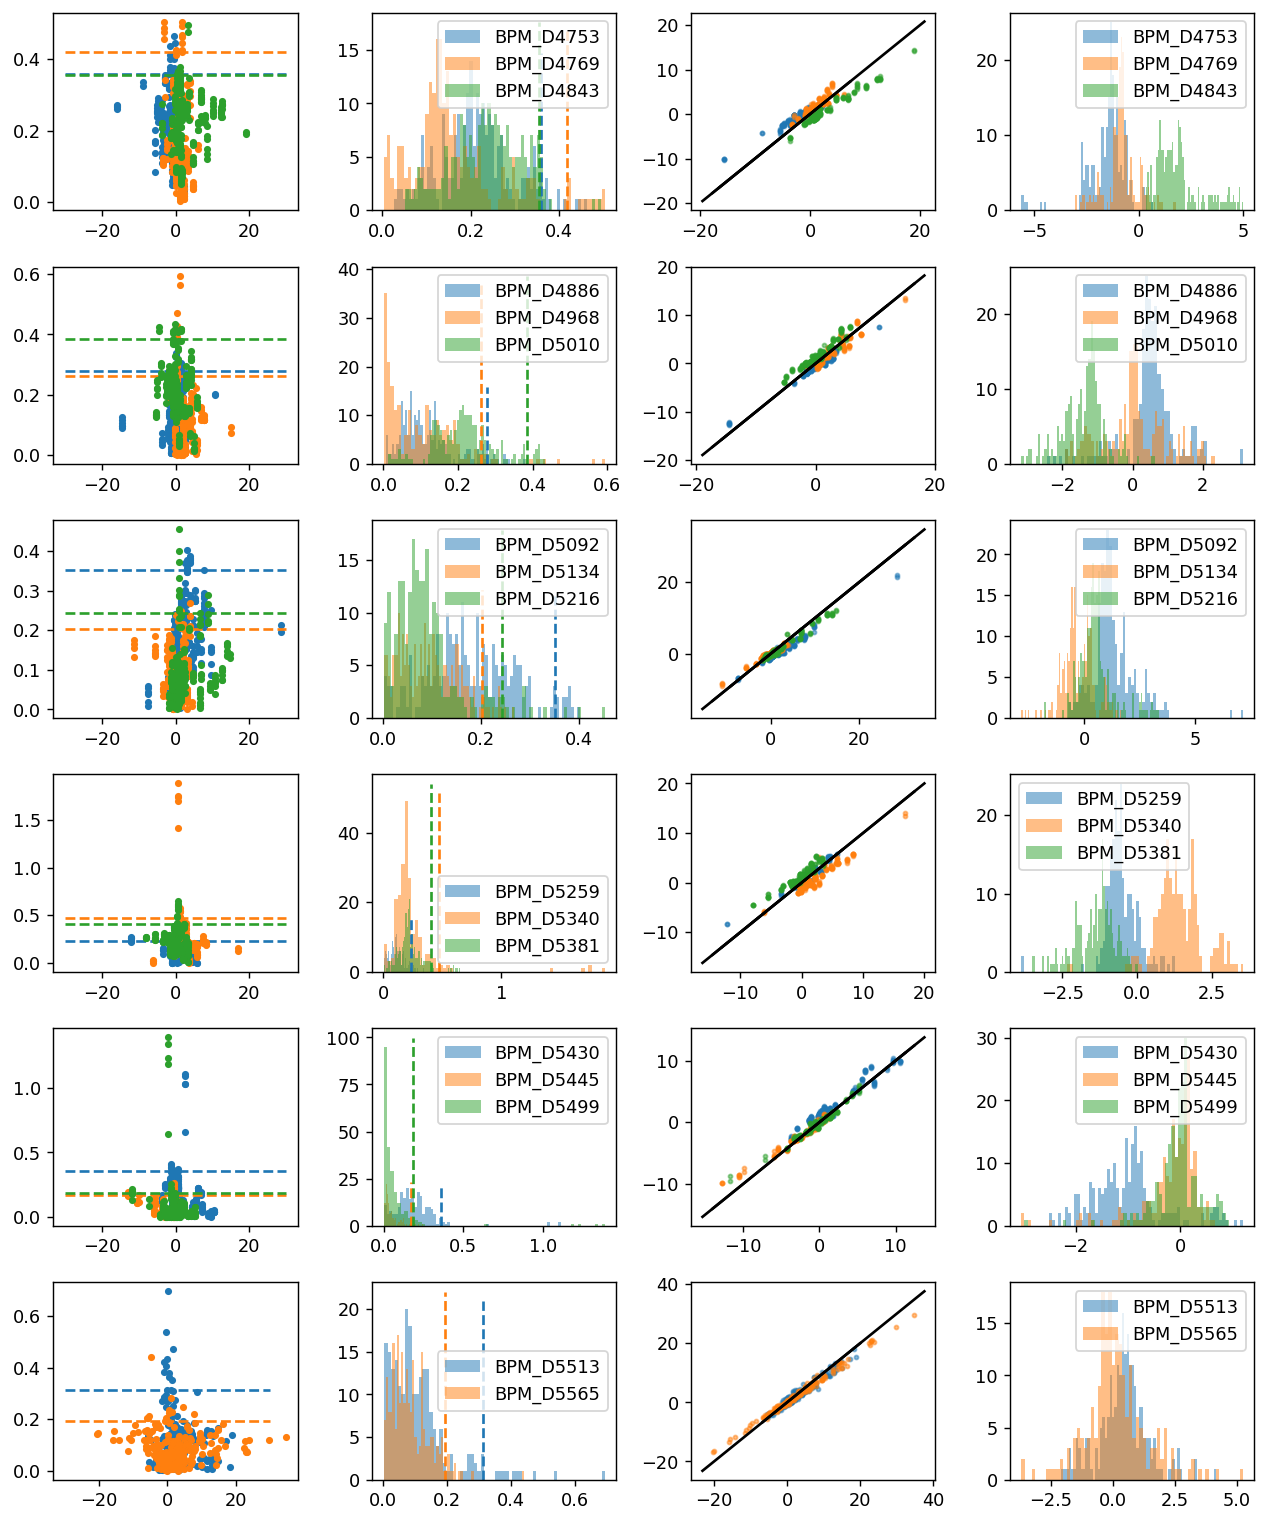

In [8]:
ISAAC_data = {}

fig,ax = plt.subplots(6,4,figsize=(10,2*6), dpi=128)
for i,bpm in enumerate(BPMs):
    meas = filtered_meas[bpm]
    mask = filtered_meas[bpm].notna().all(axis=1)
    meas = filtered_meas[bpm][mask]
    sim  = filtered_sim[bpm][mask]
    loss =  np.sqrt((meas['beamQ']-sim['beamQ'])**2/(np.abs(sim['beamQ'])+5)**2)
    cut = np.sort(loss)[int(0.95*len(loss))] 
    mask = loss < cut
    ISAAC_data[bpm] = {'measurement':meas[mask],
                       'simulation':sim[mask]}
    
    n = int(i/(len(BPMs)/6))
    c = i%3
    ax[n,0].plot(sim['beamQ'],loss,'.',c='C'+str(c),label=bpm[8:])
    ax[n,0].plot([-30,30],[cut,cut],c='C'+str(c),ls='--')
    ax[n,1].hist(loss,bins=64,alpha=0.5,color='C'+str(c),label=bpm[8:])
    ax[n,1].plot([cut,cut],ax[n,1].get_ylim(),c='C'+str(c),ls='--')
    ax[n,2].scatter(ISAAC_data[bpm]['simulation']['beamQ'],ISAAC_data[bpm]['measurement']['beamQ'],alpha=0.5,color='C'+str(c),label=bpm[8:],s=5)
    ax[n,2].plot(ax[n,2].get_xlim(),ax[n,2].get_xlim(),color='k')
    ax[n,3].hist(ISAAC_data[bpm]['simulation']['beamQ']-ISAAC_data[bpm]['measurement']['beamQ'],bins=64,alpha=0.5,color='C'+str(c),label=bpm[8:])
    
for i in range(6):
    for j in [1,3]:
        ax[i,j].legend()
plt.tight_layout()

In [9]:
all_T1 = {}
all_T2 = {}
all_T3 = {}
all_T4 = {}
all_xy = {}
all_Qsim = {}
all_Qmeas = {}
all_Qerr = {}
n_data = {}
n_train = {}
n_val = {}
np.random.seed(0)
for bpm in BPMs:
    meas = ISAAC_data[bpm]['measurement']
    sim  = ISAAC_data[bpm]['simulation']
    n_data[bpm] = len(meas)
    n_train[bpm] = int(0.7*n_data[bpm]) - 1
    n_val[bpm] = n_data[bpm] - n_train[bpm]
    print(bpm, n_data[bpm], n_train[bpm], n_val[bpm])
    p = np.random.permutation(np.arange(n_data[bpm]))
    T1 = np.stack(meas['TISRAW1'].values)/ meas["MAG"].values[:, None] *TIS161_coeffs[bpm][0] *1.1e-11 + 0.5
    T2 = np.stack(meas['TISRAW2'].values)/ meas["MAG"].values[:, None] *TIS161_coeffs[bpm][1] *1.1e-11 + 0.5
    T3 = np.stack(meas['TISRAW3'].values)/ meas["MAG"].values[:, None] *TIS161_coeffs[bpm][2] *1.1e-11 + 0.5
    T4 = np.stack(meas['TISRAW4'].values)/ meas["MAG"].values[:, None] *TIS161_coeffs[bpm][3] *1.1e-11 + 0.5
    all_T1   [bpm] = torch.tensor(T1[p],dtype=_dtype)
    all_T2   [bpm] = torch.tensor(T2[p],dtype=_dtype)
    all_T3   [bpm] = torch.tensor(T3[p],dtype=_dtype)
    all_T4   [bpm] = torch.tensor(T4[p],dtype=_dtype)
    all_xy   [bpm] = torch.tensor(np.stack(meas[['XPOS','YPOS']].values[p]),dtype=_dtype)
    all_Qsim [bpm] = torch.tensor(sim['beamQ'  ].values[p],dtype=_dtype)
    all_Qmeas[bpm] = torch.tensor(meas['beamQ'  ].values[p],dtype=_dtype)
    all_Qerr [bpm] = torch.tensor(meas['beamQ_err'].values[p],dtype=_dtype)

LS3_BTS:BPM_D4753 217 150 67
LS3_BTS:BPM_D4769 217 150 67
LS3_BTS:BPM_D4843 217 150 67
LS3_BTS:BPM_D4886 217 150 67
LS3_BTS:BPM_D4968 217 150 67
LS3_BTS:BPM_D5010 217 150 67
LS3_BTS:BPM_D5092 217 150 67
LS3_BTS:BPM_D5134 217 150 67
LS3_BTS:BPM_D5216 217 150 67
LS3_BTS:BPM_D5259 217 150 67
LS3_BTS:BPM_D5340 217 150 67
LS3_BTS:BPM_D5381 217 150 67
LS3_BTS:BPM_D5430 217 150 67
LS3_BTS:BPM_D5445 217 150 67
BDS_BTS:BPM_D5499 217 150 67
BDS_BTS:BPM_D5513 217 150 67
BDS_BTS:BPM_D5565 217 150 67


In [10]:
train_T1 = {}
train_T2 = {}
train_T3 = {}
train_T4 = {}
train_xy = {}
train_Qsim = {}
train_Qmeas = {}
train_Qerr = {}

val_T1 = {}
val_T2 = {}
val_T3 = {}
val_T4 = {}
val_xy = {}
val_Qsim = {}
val_Qmeas = {}
val_Qerr = {}

for bpm in BPMs:
    n_val = n_data[bpm] - n_train[bpm]
    
    val_T1[bpm] = all_T1[bpm][:n_val]
    val_T2[bpm] = all_T2[bpm][:n_val]
    val_T3[bpm] = all_T3[bpm][:n_val]
    val_T4[bpm] = all_T4[bpm][:n_val]
    val_xy[bpm] = all_xy[bpm][:n_val]
    val_Qsim[bpm] = all_Qsim[bpm][:n_val]
    val_Qerr[bpm] = all_Qerr[bpm][:n_val]
    val_Qmeas[bpm] = all_Qmeas[bpm][:n_val]
    
    train_T1[bpm] = all_T1[bpm][n_val:]
    train_T2[bpm] = all_T2[bpm][n_val:]
    train_T3[bpm] = all_T3[bpm][n_val:]
    train_T4[bpm] = all_T4[bpm][n_val:]
    train_xy[bpm] = all_xy[bpm][n_val:]
    train_Qsim[bpm] = all_Qsim[bpm][n_val:]
    train_Qerr[bpm] = all_Qerr[bpm][n_val:]
    train_Qmeas[bpm] = all_Qmeas[bpm][n_val:]

# train model

In [ ]:
models = {}
history = {}

for bpm in BPMs:
    print(bpm)
    fname = bpm.replace('_D','')[-7:]
    if not os.path.exists(fname):
        os.makedirs(fname)
    model_info = {'F':1,
                  'dtype':_dtype}
    model = TISRAW2BPMQ_model(**model_info)
    if bpm in val_T1:
        hist_,model_state_dict_,opt_state_dict_ = train_TISRAW2BPMQ_model(
            model,epochs,lr,
            prior_T1[bpm],prior_T2[bpm],prior_T3[bpm],prior_T4[bpm],prior_xy[bpm],prior_Qsim[bpm],prior_Qerr[bpm],
            val_T1[bpm],val_T2[bpm],val_T3[bpm],val_T4[bpm],val_xy[bpm],val_Qsim[bpm],val_Qerr[bpm],
            lr_scheduler = False,
            batch_size = int(0.1*len(prior_T1)),
            fname_model = fname+'/model_TISRAW2BPMQ.pt',
            fname_history = fname+'/history_TISRAW2BPMQ.pkl',
        )
    else:
        hist_,model_state_dict_,opt_state_dict_ = train_TISRAW2BPMQ_model(
            model,epochs,lr,
            prior_T1[bpm],prior_T2[bpm],prior_T3[bpm],prior_T4[bpm],prior_xy[bpm],prior_Qsim[bpm],prior_Qerr[bpm],
            validation_split = 0.3,
            lr_scheduler = False,
            batch_size = int(0.1*len(prior_T1)),
            fname_model = fname+'/model_TISRAW2BPMQ.pt',
            fname_history = fname+'/history_TISRAW2BPMQ.pkl',
        )
    if bpm in val_T1:
        hist_,model_state_dict_,opt_state_dict_ = train_TISRAW2BPMQ_model(
            model,epochs,lr,
            train_T1[bpm],train_T2[bpm],train_T3[bpm],train_T4[bpm],train_xy[bpm],train_Qsim[bpm],train_Qerr[bpm],
            val_T1[bpm],val_T2[bpm],val_T3[bpm],val_T4[bpm],val_xy[bpm],val_Qsim[bpm],val_Qerr[bpm],
            batch_size = int(0.1*len(train_T1)),
            optimizer_state_dict = opt_state_dict_,
            prev_history = hist_,
            fname_model = fname+'/model_TISRAW2BPMQ.pt',
            fname_history = fname+'/history_TISRAW2BPMQ.pkl',
        )
    hist_,model_state_dict_,opt_state_dict_ = train_TISRAW2BPMQ_model(
        model,int(0.1*epochs),0.01*lr,
        all_T1[bpm],all_T2[bpm],all_T3[bpm],all_T4[bpm],all_xy[bpm],all_Qsim[bpm],all_Qerr[bpm],
        lr_scheduler = False,
        batch_size = int(0.1*len(all_T1)),
        optimizer_state_dict = opt_state_dict_,
        prev_history = hist_,
        fname_model = fname+'/model_TISRAW2BPMQ.pt',
        fname_history = fname+'/history_TISRAW2BPMQ.pkl',
    )
    models[bpm] = model
    history[bpm] = hist_

LS3_BTS:BPM_D4753
LS3_BTS:BPM_D4769
LS3_BTS:BPM_D4843
LS3_BTS:BPM_D4886
LS3_BTS:BPM_D4968
LS3_BTS:BPM_D5010


In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(10, 6),dpi=128)  # Corrected figsize
ax = ax.flatten()

for i, bpm in enumerate(BPMs):    
    n = int(i/(len(BPMs)/6))
    c = 'C' + str(i % 3)
    ax[n].plot(history[bpm]['train_loss'], c=c, label=f'{bpm[8:]}')
    ax[n].plot(history[bpm]['val_loss'], '--', c=c)

for i in range(6):
    ax[i].set_xlabel('epoch')
    ax[i].set_ylabel('loss')
    ax[i].legend()
    xlim = ax[i].get_xlim()
    ylim = ax[i].get_ylim()
    ax[i].text(0.25*xlim[0]+0.75*xlim[1],0.4*ylim[0]+0.6*ylim[1], "── Train",ha='left')
    ax[i].text(0.25*xlim[0]+0.75*xlim[1],0.5*ylim[0]+0.5*ylim[1], "---- Val",ha='left')

plt.tight_layout()
plt.show()

In [ ]:
train_Qpred = {}
with torch.no_grad():
    for bpm in BPMs:
        model = models[bpm]
        feature, train_Qpred[bpm] = model(train_T1[bpm],train_T2[bpm],train_T3[bpm],train_T4[bpm],train_xy[bpm])
        train_Qpred[bpm] = train_Qpred[bpm].view(-1).detach()

fig, ax = plt.subplots(len(BPMs), 2, figsize=(6, 3*len(BPMs)), dpi=128)  # Corrected figsize
for i, bpm in enumerate(BPMs):    
    ax[i,0].scatter(train_Qsim[bpm], train_Qmeas[bpm],label='original',s=5)
    ax[i,0].scatter(train_Qsim[bpm], train_Qpred[bpm],label='NN',s=5)
    ax[i,0].plot([-25, 25], [-25, 25], color='k')
    ax[i,0].set_xlabel('simulated BPMQ $(mm^2)$')
    ax[i,0].set_ylabel('predicted BPMQ $(mm^2)$')
    ax[i,0].legend()

    # Second subplot in the row
    ax[i,1].scatter(train_Qsim[bpm], train_Qmeas[bpm]-train_Qsim[bpm],label='original',s=5)
    ax[i,1].scatter(train_Qsim[bpm], train_Qpred[bpm]-train_Qsim[bpm],label='NN',s=5)
    ax[i,1].set_xlabel('simulated BPMQ $(mm^2)$')
    ax[i,1].set_ylabel('prediction err $(mm^2)$')
    ax[i,1].set_xlim(-25,25)
    ax[i,1].set_ylim(-7, 7)
    ax[i,1].legend()
    # Set a single title for each row on the first subplot
    ax[i, 0].set_title(bpm)
plt.tight_layout()

In [ ]:
val_Qpred = {}
with torch.no_grad():
    for bpm in BPMs:
        model = models[bpm]
        feature, val_Qpred[bpm] = model(val_T1[bpm],val_T2[bpm],val_T3[bpm],val_T4[bpm],val_xy[bpm])
        val_Qpred[bpm] = val_Qpred[bpm].view(-1).detach()

fig, ax = plt.subplots(len(BPMs), 2, figsize=(6, 3*len(BPMs)), dpi=128)  # Corrected figsize
for i, bpm in enumerate(BPMs):    
    ax[i,0].scatter(val_Qsim[bpm], val_Qmeas[bpm],label='original',s=5)
    ax[i,0].scatter(val_Qsim[bpm], val_Qpred[bpm],label='NN',s=5)
    ax[i,0].plot([-25, 25], [-25, 25], color='k')
    ax[i,0].set_xlabel('simulated BPMQ $(mm^2)$')
    ax[i,0].set_ylabel('predicted BPMQ $(mm^2)$')
    ax[i,0].legend()

    # Second subplot in the row
    ax[i,1].scatter(val_Qsim[bpm], val_Qmeas[bpm]-val_Qsim[bpm],label='original',s=5)
    ax[i,1].scatter(val_Qsim[bpm], val_Qpred[bpm]-val_Qsim[bpm],label='NN',s=5)
    ax[i,1].set_xlabel('simulated BPMQ $(mm^2)$')
    ax[i,1].set_ylabel('prediction err $(mm^2)$')
    ax[i,1].set_xlim(-25,25)
    ax[i,1].set_ylim(-7, 7)
    ax[i,1].legend()
    # Set a single title for each row on the first subplot
    ax[i, 0].set_title(bpm)
plt.tight_layout()

# use NN as feature extractor and use GP for BPMQ pred model with uncertainty

In [ ]:
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from gpytorch.mlls import ExactMarginalLogLikelihood

In [ ]:
GPs = {}
for bpm in BPMs:
    fname = bpm.replace('_D','')[-7:] 
    with torch.no_grad():
        model = models[bpm].eval()
        x, _ = model(train_T1[bpm],train_T2[bpm],train_T3[bpm],train_T4[bpm],train_xy[bpm])
        y = train_Qsim[bpm]
        yerr = torch.sqrt(0.5*train_Qerr[bpm]**2 + 0.5*0.5**2)
        # yerr = torch.sqrt( 0.25*y**2 + 0.25*(train_Qmeas[bpm] - train_Qsim[bpm])**2 +  0.25*train_Qerr[bpm]**2 + 0.25*0.5**2)
        
        x_max, x_min = x.max(dim=0).values.view(1,-1), x.min(dim=0).values.view(1,-1)
        y_mean, y_std = y.mean(), y.std()
        train_x = (x - x_min)/(x_max-x_min)
        train_y = (y - y_mean)/y_std
        train_yvar = (yerr/y_std)**2
        train_x = train_x.to(torch.float64)
        train_y = train_y.to(torch.float64).view(-1,1)
        train_yvar = train_yvar.to(torch.float64).view(-1,1)
    gp = SingleTaskGP(train_x, train_y, train_Yvar = train_yvar)
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    fit_gpytorch_mll(mll)
        
    torch.save({
        "state_dict": gp.state_dict(),
        "train_x": train_x, 
        "train_y": train_y,
        "train_yvar": train_yvar,
        "x_max":x_max,
        "x_min":x_min,
        "y_mean":y_mean,
        "y_std":y_std,
        }, fname+'/gp_TISRAW2BPMQ.pt')

In [ ]:
val_Q_GPpred = {}
train_Q_GPpred = {}

with torch.no_grad():
    for bpm in BPMs:
        fname = bpm.replace('_D', '')[-7:] 
        model = models[bpm]
        
        # Load the checkpoint
        checkpoints = torch.load(fname + '/gp_TISRAW2BPMQ.pt')
        
        # Extract data from the checkpoint
        train_x = checkpoints['train_x']
        train_y = checkpoints['train_y']
        train_yvar = checkpoints['train_yvar']
        x_max = checkpoints['x_max']
        x_min = checkpoints['x_min']
        y_mean = checkpoints['y_mean']
        y_std = checkpoints['y_std']
        
        # Initialize and load the GP model
        gp = SingleTaskGP(train_x, train_y, train_yvar)
        gp.load_state_dict(checkpoints['state_dict'])
        
        # Get features and predictions from the model
        train_feature, _ = model(train_T1[bpm], train_T2[bpm], train_T3[bpm], train_T4[bpm], train_xy[bpm])
        val_feature, _ = model(val_T1[bpm], val_T2[bpm], val_T3[bpm], val_T4[bpm], val_xy[bpm])
        
        # Scale the features
        train_x_scaled = (train_feature - x_min) / (x_max - x_min)
        val_x_scaled = (val_feature - x_min) / (x_max - x_min)
        
        # Get GP predictions
        train_ypred = gp.posterior(train_x_scaled)
        val_ypred = gp.posterior(val_x_scaled)
        
        # Unscale the predictions
        train_Q_GPpred[bpm] = {
            'mean': train_ypred.mean * y_std + y_mean,
            'std': train_ypred.stddev * y_std,
        }
        val_Q_GPpred[bpm] = {
            'mean': val_ypred.mean * y_std + y_mean,
            'std': val_ypred.stddev * y_std,
        }

##### GP prediction on train data

In [ ]:
# Plotting
fig, ax = plt.subplots(len(BPMs), 3, figsize=(9, 3*len(BPMs)), dpi=128)  # Corrected figsize
for i, bpm in enumerate(BPMs):    
    # Flatten the mean and std arrays
    mean = train_Q_GPpred[bpm]['mean'].flatten()
    std = train_Q_GPpred[bpm]['std'].flatten()   # 2-sigma error bars
    
    # First subplot in the row
    ax[i, 0].scatter(train_Qsim[bpm], train_Qmeas[bpm], label='original',s=5)
    ax[i, 0].errorbar(train_Qsim[bpm], mean, std, fmt='.', linestyle='none', capsize=5, capthick=2, label='GP 2$\sigma$', color='C1', alpha=0.5)
    ax[i, 0].plot([-25, 25], [-25, 25], color='k')
    ax[i, 0].set_xlabel('simulated BPMQ $(mm^2)$')
    ax[i ,0].set_ylabel('predicted BPMQ $(mm^2)$')
    ax[i, 0].legend()

    # Second subplot in the row
    ax[i, 1].scatter(train_Qsim[bpm], train_Qmeas[bpm] - train_Qsim[bpm], label='original',s=5)
    ax[i, 1].errorbar(train_Qsim[bpm], mean - train_Qsim[bpm], std, fmt='.', linestyle='none', capsize=5, capthick=2, label='GP 2$\sigma$', color='C1', alpha=0.5)
    ax[i, 1].set_xlabel('simulated BPMQ $(mm^2)$')
    ax[i ,1].set_ylabel('prediction err $(mm^2)$')
    ax[i, 1].set_xlim(-25, 25)
    ax[i, 1].set_ylim(-7, 7)
    ax[i, 1].legend()

    # Third subplot in the row
    err = torch.abs(mean - train_Qsim[bpm])
    unc = 2 * std
    
    ax[i, 2].scatter(err, unc)
    xmin = min(min(ax[i, 2].get_xlim()), min(ax[i, 2].get_ylim()))
    xmax = max(max(ax[i, 2].get_xlim()), max(ax[i, 2].get_ylim()))
    ax[i, 2].set_xlabel('mean prediction err $(mm^2)$')
    ax[i, 2].set_ylabel('pred uncertainty ($2\sigma$) $(mm^2)$')
    ax[i, 2].plot([xmin, xmax], [xmin, xmax], 'k')
    
    # Set a single title for each row on the first subplot
    ax[i, 1].set_title(bpm)

plt.tight_layout()
plt.show()

##### GP prediction on val data

In [ ]:
# Plotting
fig, ax = plt.subplots(len(BPMs), 3, figsize=(9, 3*len(BPMs)), dpi=128)  # Corrected figsize
for i, bpm in enumerate(BPMs):    
    # Flatten the mean and std arrays
    mean = val_Q_GPpred[bpm]['mean'].flatten()
    std = val_Q_GPpred[bpm]['std'].flatten()   # 2-sigma error bars
    
    # First subplot in the row
    ax[i, 0].scatter(val_Qsim[bpm], val_Qmeas[bpm], label='original',s=5)
    ax[i, 0].errorbar(val_Qsim[bpm], mean, std, fmt='.', linestyle='none', capsize=5, capthick=2, label='GP 2$\sigma$', color='C1', alpha=0.5)
    ax[i, 0].plot([-25, 25], [-25, 25], color='k')
    ax[i, 0].set_xlabel('simulated BPMQ $(mm^2)$')
    ax[i ,0].set_ylabel('predicted BPMQ $(mm^2)$')
    ax[i, 0].legend()

    # Second subplot in the row
    ax[i, 1].scatter(val_Qsim[bpm], val_Qmeas[bpm] - val_Qsim[bpm], label='original',s=5)
    ax[i, 1].errorbar(val_Qsim[bpm], mean - val_Qsim[bpm], std, fmt='.', linestyle='none', capsize=5, capthick=2, label='GP 2$\sigma$', color='C1', alpha=0.5)
    ax[i, 1].set_xlabel('simulated BPMQ $(mm^2)$')
    ax[i ,1].set_ylabel('prediction err $(mm^2)$')
    ax[i, 1].set_xlim(-25, 25)
    ax[i, 1].set_ylim(-7, 7)
    ax[i, 1].legend()

    # Third subplot in the row
    err = torch.abs(mean - val_Qsim[bpm])
    unc = 2 * std
    
    ax[i, 2].scatter(err, unc)
    xmin = min(min(ax[i, 2].get_xlim()), min(ax[i, 2].get_ylim()))
    xmax = max(max(ax[i, 2].get_xlim()), max(ax[i, 2].get_ylim()))
    ax[i, 2].set_xlabel('mean prediction err $(mm^2)$')
    ax[i, 2].set_ylabel('pred uncertainty ($2\sigma$) $(mm^2)$')
    ax[i, 2].plot([xmin, xmax], [xmin, xmax], 'k')
    
    # Set a single title for each row on the first subplot
    ax[i, 1].set_title(bpm)

plt.tight_layout()
plt.show()

### train GP with all data

In [ ]:
GPs = {}
for bpm in BPMs:
    fname = bpm.replace('_D','')[-7:] 
    with torch.no_grad():
        model = models[bpm].eval()
        x, _ = model(all_T1[bpm],all_T2[bpm],all_T3[bpm],all_T4[bpm],all_xy[bpm])
        y = all_Qsim[bpm]
        yerr = torch.sqrt(0.5*all_Qerr[bpm]**2 + 0.5*0.5**2)
        # yerr = torch.sqrt( 0.25*y**2 + 0.25*(all_Qmeas[bpm] - all_Qsim[bpm])**2 +  0.25*all_Qerr[bpm]**2 + 0.25*0.5**2)
        
        x_max, x_min = x.max(dim=0).values.view(1,-1), x.min(dim=0).values.view(1,-1)
        y_mean, y_std = y.mean(), y.std()
        all_x = (x - x_min)/(x_max-x_min)
        all_y = (y - y_mean)/y_std
        all_yvar = (yerr/y_std)**2
        all_x = all_x.to(torch.float64)
        all_y = all_y.to(torch.float64).view(-1,1)
        all_yvar = all_yvar.to(torch.float64).view(-1,1)
    gp = SingleTaskGP(all_x, all_y, train_Yvar = all_yvar)
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    fit_gpytorch_mll(mll)
        
    torch.save({
        "state_dict": gp.state_dict(),
        "train_x": all_x, 
        "train_y": all_y,
        "train_yvar": all_yvar,
        "x_max":x_max,
        "x_min":x_min,
        "y_mean":y_mean,
        "y_std":y_std,
        }, fname+'/gp_TISRAW2BPMQ.pt')